## Feature Engineering First: Adding t-12 for more context

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader

In [3]:
import torch.nn as nn

In [118]:
# Load and sort dataset
df = pd.read_csv("data/model_ready_weekly_weather_12WeekWindow.csv")
df['WEEK'] = pd.to_datetime(df['WEEK'])
df['WeekOfYear'] = df['WEEK'].dt.isocalendar().week.astype(int)
df['Year'] = df['WEEK'].dt.year

feature_cols = ['Season', 'WeekOfYear', 'Year'] + \
               [f'Avg_Temp_t-{i}' for i in range(12, 0, -1)] + ['Avg_Temp'] + \
               [f'Avg_Precip_t-{i}' for i in range(12, 0, -1)]


In [119]:
X = df[feature_cols].values
y = df['Target_Precip'].values

# Chronological split: 70% train · 10% val · 20% test
n = len(X)
n_train = int(0.7 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val

X_train, X_val, X_test = X[:n_train], X[n_train:n_train+n_val], X[n_train+n_val:]
y_train, y_val, y_test = y[:n_train], y[n_train:n_train+n_val], y[n_train+n_val:]

In [120]:
X_train[0]

array([ 1.00000000e+00,  1.20000000e+01,  2.00500000e+03,  3.60000000e+00,
        2.05714286e+00,  2.30000000e+00, -9.84285714e+00, -7.25714286e+00,
       -9.42857143e-01,  2.05714286e+00,  3.28571429e-01, -3.01428571e+00,
       -1.51428571e+00, -1.27142857e+00,  3.71428571e+00,  3.95714286e+00,
        5.00000000e-01,  4.55000000e+01,  2.14000000e+01,  3.82000000e+01,
        7.60000000e+00,  6.80000000e+00,  2.29000000e+01,  1.37000000e+01,
        1.88000000e+01,  2.16000000e+01,  3.32000000e+01,  0.00000000e+00])

In [121]:
df.head()

,Season,WEEK,Avg_Temp_t-12,Avg_Temp_t-11,Avg_Temp_t-10,Avg_Temp_t-9,Avg_Temp_t-8,Avg_Temp_t-7,Avg_Temp_t-6,Avg_Temp_t-5,...,Avg_Precip_t-7,Avg_Precip_t-6,Avg_Precip_t-5,Avg_Precip_t-4,Avg_Precip_t-3,Avg_Precip_t-2,Avg_Precip_t-1,Target_Precip,WeekOfYear,Year
0,1,2005-03-21,3.600000,2.057143,2.300000,-9.842857,-7.257143,-0.942857,2.057143,0.328571,...,6.8,22.9,13.7,18.8,21.6,33.2,0.0,4.8,12,2005
1,1,2005-03-28,2.057143,2.300000,-9.842857,-7.257143,-0.942857,2.057143,0.328571,-3.014286,...,22.9,13.7,18.8,21.6,33.2,0.0,4.8,77.5,13,2005
2,1,2005-04-04,2.300000,-9.842857,-7.257143,-0.942857,2.057143,0.328571,-3.014286,-1.514286,...,13.7,18.8,21.6,33.2,0.0,4.8,77.5,7.3,14,2005
3,1,2005-04-11,-9.842857,-7.257143,-0.942857,2.057143,0.328571,-3.014286,-1.514286,-1.271429,...,18.8,21.6,33.2,0.0,4.8,77.5,7.3,0.8,15,2005
4,1,2005-04-18,-7.257143,-0.942857,2.057143,0.328571,-3.014286,-1.514286,-1.271429,3.714286,...,21.6,33.2,0.0,4.8,77.5,7.3,0.8,22.6,16,2005


In [122]:
y_train[0]

4.8

In [123]:
x_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train.reshape(-1, 1))

print(x_scaler.mean_)

[1.51452282e+00 2.67524205e+01 2.01163347e+03 1.12544705e+01
 1.12614750e+01 1.12629767e+01 1.12599289e+01 1.12799546e+01
 1.12916914e+01 1.12944033e+01 1.12974511e+01 1.13001136e+01
 1.13088569e+01 1.13085013e+01 1.13073553e+01 1.12986317e+01
 2.29754495e+01 2.30712310e+01 2.30901107e+01 2.31062932e+01
 2.31273167e+01 2.31238589e+01 2.31239281e+01 2.31329876e+01
 2.31260028e+01 2.31490318e+01 2.31240664e+01 2.31253804e+01]


In [124]:
X_train_scaled = x_scaler.transform(X_train)
X_val_scaled = x_scaler.transform(X_val)
X_test_scaled = x_scaler.transform(X_test)

X_train_scaled[0]

array([-0.46203516, -0.98276493, -1.65723153, -0.83132202, -1.00007004,
       -0.97399584, -2.29238411, -2.02030915, -1.33607732, -1.00912504,
       -1.19865071, -1.56473838, -1.40336276, -1.37666964, -0.83079038,
       -0.80236422, -0.9422885 ,  0.93842141, -0.07064611,  0.63083829,
       -0.648421  , -0.68161567, -0.00935031, -0.39386369, -0.18060105,
       -0.06465831,  0.42038756, -0.96481259])

In [125]:
y_train_scaled = y_scaler.transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

y_train_scaled[0]

-0.7669206216777277

In [126]:
train_ds = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32),
                         torch.tensor(y_train_scaled, dtype=torch.float32))
val_ds = TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32),
                       torch.tensor(y_val_scaled, dtype=torch.float32))
test_ds = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32),
                        torch.tensor(y_test_scaled, dtype=torch.float32))

print(len(train_ds), len(val_ds), len(test_ds))
train_ds[0]

723 103 207


(tensor([-0.4620, -0.9828, -1.6572, -0.8313, -1.0001, -0.9740, -2.2924, -2.0203,
         -1.3361, -1.0091, -1.1987, -1.5647, -1.4034, -1.3767, -0.8308, -0.8024,
         -0.9423,  0.9384, -0.0706,  0.6308, -0.6484, -0.6816, -0.0094, -0.3939,
         -0.1806, -0.0647,  0.4204, -0.9648]),
 tensor(-0.7669))

In [127]:

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

## print out first batch of train_loader
# for batch in train_loader:
#     X_batch, y_batch = batch
#     print(X_batch)
#     print(y_batch)
#     break

In [128]:
# for batch in train_loader:
#     X_batch, y_batch = batch
#     print(X_batch)
#     print(y_batch)
    

In [78]:


class SimpleMLP(nn.Module):
    def __init__(self, input_dim):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(1)  # shape: (batch_size,)




In [79]:
def train_model(model, train_loader, val_loader, epochs=40, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        train_losses = []
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = model(x_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                preds = model(x_batch)
                loss = criterion(preds, y_batch)
                val_losses.append(loss.item())

        print(f"Epoch {epoch+1:02d} - Train Loss: {np.mean(train_losses):.4f}, Val Loss: {np.mean(val_losses):.4f}")

    return model


In [80]:
input_dim = X_train_scaled.shape[1]
model = SimpleMLP(input_dim)
trained_model = train_model(model, train_loader, val_loader)


Epoch 01 - Train Loss: 1.0215, Val Loss: 0.8305
Epoch 02 - Train Loss: 0.9835, Val Loss: 0.8102
Epoch 03 - Train Loss: 0.9616, Val Loss: 0.7917
Epoch 04 - Train Loss: 0.9437, Val Loss: 0.7823
Epoch 05 - Train Loss: 0.9370, Val Loss: 0.7700
Epoch 06 - Train Loss: 0.9336, Val Loss: 0.7610
Epoch 07 - Train Loss: 0.9253, Val Loss: 0.7569
Epoch 08 - Train Loss: 0.9299, Val Loss: 0.7474
Epoch 09 - Train Loss: 0.9250, Val Loss: 0.7508
Epoch 10 - Train Loss: 0.9009, Val Loss: 0.7453
Epoch 11 - Train Loss: 0.9003, Val Loss: 0.7444
Epoch 12 - Train Loss: 0.8821, Val Loss: 0.7388
Epoch 13 - Train Loss: 0.9059, Val Loss: 0.7396
Epoch 14 - Train Loss: 0.8547, Val Loss: 0.7415
Epoch 15 - Train Loss: 0.9044, Val Loss: 0.7363
Epoch 16 - Train Loss: 0.9413, Val Loss: 0.7364
Epoch 17 - Train Loss: 0.8663, Val Loss: 0.7360
Epoch 18 - Train Loss: 0.8693, Val Loss: 0.7396
Epoch 19 - Train Loss: 0.8499, Val Loss: 0.7367
Epoch 20 - Train Loss: 0.8425, Val Loss: 0.7394
Epoch 21 - Train Loss: 0.8311, Val Loss:

In [73]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [72]:
def regression_accuracy(y_true, y_pred, threshold=5.0):
    return np.mean(np.abs(y_true - y_pred) <= threshold)


In [87]:
def evaluate_model(model, test_loader, y_scaler):
    model.eval()
    device = next(model.parameters()).device
    preds, targets = [], []

    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            preds_batch = model(x_batch).cpu().numpy()
            y_batch = y_batch.numpy()
            preds.extend(preds_batch)
            targets.extend(y_batch)

    preds_inv = y_scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
    targets_inv = y_scaler.inverse_transform(np.array(targets).reshape(-1, 1)).flatten()

    rmse = mean_squared_error(targets_inv, preds_inv, squared=False)
    mae = mean_absolute_error(targets_inv, preds_inv)
    r2 = r2_score(targets_inv, preds_inv)
    accuracy_5mm = regression_accuracy(targets_inv, preds_inv, threshold=5.0)



    print(f"✅ Final Test Evaluation:")
    print(f"   RMSE: {rmse:.2f}")
    print(f"   MAE : {mae:.2f}")
    print(f"   R²  : {r2:.2f}")
    print(f"   Accuracy (within ±5mm): {accuracy_5mm*100:.2f}%")

    return preds_inv, targets_inv

In [71]:
def plot_predictions(preds, targets, title="Test Predictions vs Ground Truth"):
    plt.figure(figsize=(12, 5))
    plt.plot(targets, label="True", linewidth=2)
    plt.plot(preds, label="Predicted", linestyle='--')
    plt.title(title)
    plt.xlabel("Test Sample Index")
    plt.ylabel("Precipitation")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


✅ Final Test Evaluation:
   RMSE: 27.72
   MAE : 21.23
   R²  : -0.28
   Accuracy (within ±5mm): 12.56%


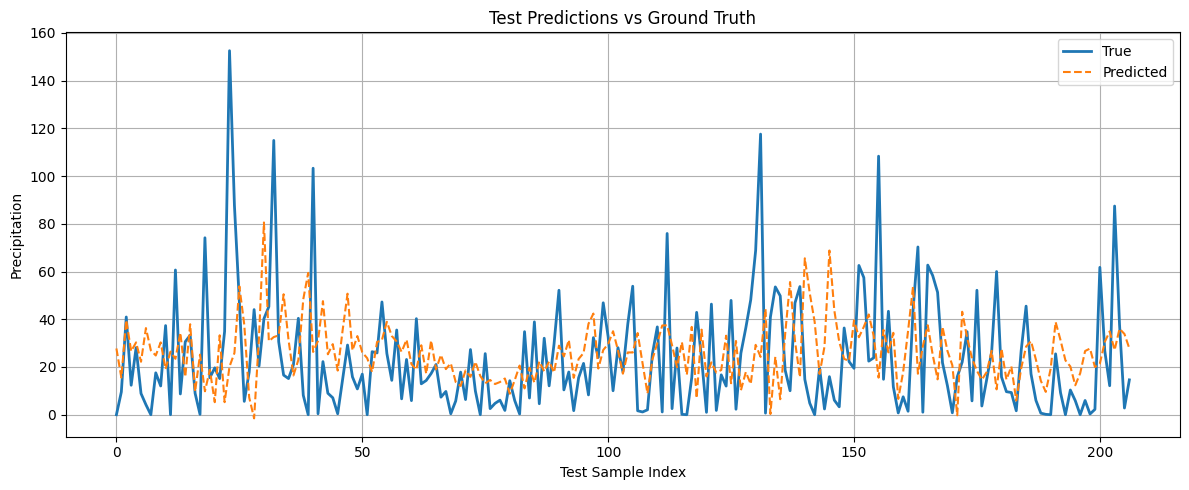

In [82]:
preds_inv, targets_inv = evaluate_model(trained_model, test_loader, y_scaler)
plot_predictions(preds_inv, targets_inv)


## Improved Model Comparison

In [54]:


# class ImprovedMLP(nn.Module):
#     def __init__(self, input_dim, dropout_rate=0.3):
#         super(ImprovedMLP, self).__init__()
#         self.net = nn.Sequential(
#             nn.Linear(input_dim, 64),
#             nn.BatchNorm1d(64),
#             nn.LeakyReLU(),
#             nn.Dropout(dropout_rate),
#             nn.Linear(64, 64),
#             nn.LeakyReLU(),
#             nn.Dropout(dropout_rate),
#             nn.Linear(64, 1)
#         )

#     def forward(self, x):
#         return self.net(x).squeeze(1)


class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, dropout=0.2):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(1)


class ImprovedMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, dropout=0.2):
        super(ImprovedMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(1)


In [56]:
# def train_model(model, train_loader, val_loader, loss_name='mse', epochs=40, lr=1e-3):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model = model.to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#     if loss_name == 'mse':
#         criterion = nn.MSELoss()
#     elif loss_name == 'huber':
#         criterion = nn.HuberLoss()

#     best_val_loss = float('inf')
#     model.train()
#     for epoch in range(epochs):
#         for x_batch, y_batch in train_loader:
#             x_batch, y_batch = x_batch.to(device), y_batch.to(device)
#             optimizer.zero_grad()
#             preds = model(x_batch)
#             loss = criterion(preds, y_batch)
#             loss.backward()
#             optimizer.step()

#         # Optionally track validation loss
#         model.eval()
#         val_losses = []
#         with torch.no_grad():
#             for x_batch, y_batch in val_loader:
#                 x_batch, y_batch = x_batch.to(device), y_batch.to(device)
#                 preds = model(x_batch)
#                 val_loss = criterion(preds, y_batch)
#                 val_losses.append(val_loss.item())
#         model.train()

#         avg_val = np.mean(val_losses)
#         if avg_val < best_val_loss:
#             best_val_loss = avg_val
#             best_model = model.state_dict()

#     model.load_state_dict(best_model)
#     return model


## Comparative Loop

In [ ]:
# best_val_loss = float('inf')
# best_model = None
# dropout_rates = [0.1, 0.2, 0.3, 0.4]

# for d in dropout_rates:
#     print(f"\nTraining with dropout = {d}")
#     model = ImprovedMLP(input_dim=X_train_scaled.shape[1], dropout_rate=d)
#     trained_model = train_model(model, train_loader, val_loader)
    
#     # Evaluate on val set (use evaluate_model but skip plotting)
#     _, val_targets = evaluate_model(trained_model, val_loader, y_scaler)
#     val_rmse = mean_squared_error(val_targets, _)  # Just for example
#     print(f"Validation RMSE for dropout {d}: {val_rmse:.2f}")

#     if val_rmse < best_val_loss:
#         best_val_loss = val_rmse
#         best_model = trained_model


results = []

model_classes = {
    "SimpleMLP": SimpleMLP,
    "ImprovedMLP": ImprovedMLP
}

hidden_sizes = [32, 64, 128]
dropout_rates = [0.1, 0.2, 0.3]
losses = ['mse', 'huber']

for model_name, model_class in model_classes.items():
    for hidden_size in hidden_sizes:
        for dropout in dropout_rates:
            for loss_name in losses:
                print(f"\nTraining {model_name} | hidden={hidden_size} | dropout={dropout} | loss={loss_name}")

                model = model_class(input_dim=X_train_scaled.shape[1],
                                    hidden_dim=hidden_size,
                                    dropout=dropout)
                trained_model = train_model(model, train_loader, val_loader,
                                            loss_name=loss_name, epochs=20)

                # Evaluate on test set
                preds_inv, targets_inv = evaluate_model(trained_model, test_loader, y_scaler)
                rmse = mean_squared_error(targets_inv, preds_inv, squared=False)
                mae = mean_absolute_error(targets_inv, preds_inv)

                results.append({
                    'Model': model_name,
                    'Hidden': hidden_size,
                    'Dropout': dropout,
                    'Loss': loss_name,
                    'Test_RMSE': rmse,
                    'Test_MAE': mae
                })

# Convert to DataFrame and print sorted
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Test_RMSE').reset_index(drop=True)

from IPython.display import display
display(results_df)

# Print best configuration
best_row = results_df.iloc[0]
print(f"\n🏆 Best Configuration:")
print(best_row)


In [58]:
epoch_list = [10, 20, 30, 40, 60, 80]
epoch_results = []

for num_epochs in epoch_list:
    print(f"\n⏳ Training for {num_epochs} epochs...")

    model = ImprovedMLP(input_dim=X_train_scaled.shape[1], hidden_dim=32, dropout=0.2)
    trained_model = train_model(model, train_loader, val_loader, loss_name='mse', epochs=num_epochs)

    preds_inv, targets_inv = evaluate_model(trained_model, test_loader, y_scaler)
    rmse = mean_squared_error(targets_inv, preds_inv, squared=False)
    mae = mean_absolute_error(targets_inv, preds_inv)

    epoch_results.append({
        "Epochs": num_epochs,
        "Test_RMSE": rmse,
        "Test_MAE": mae
    })

# Display results
epoch_results_df = pd.DataFrame(epoch_results).sort_values(by="Test_RMSE")
from IPython.display import display
display(epoch_results_df)

# Print best
print("\n🏆 Best epoch count:")
print(epoch_results_df.iloc[0])



⏳ Training for 10 epochs...


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test RMSE: 24.77
Test MAE: 18.01

⏳ Training for 20 epochs...


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test RMSE: 25.24
Test MAE: 18.76

⏳ Training for 30 epochs...


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test RMSE: 26.95
Test MAE: 19.88

⏳ Training for 40 epochs...


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test RMSE: 26.45
Test MAE: 19.27

⏳ Training for 60 epochs...


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test RMSE: 26.71
Test MAE: 19.59

⏳ Training for 80 epochs...
Test RMSE: 26.47
Test MAE: 18.99


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Epochs,Test_RMSE,Test_MAE
0,10,24.774635,18.007938
1,20,25.238718,18.755230
3,40,26.447201,19.270044
5,80,26.467430,18.989168
4,60,26.711315,19.594574
2,30,26.947441,19.880627



🏆 Best epoch count:
Epochs       10.000000
Test_RMSE    24.774635
Test_MAE     18.007938
Name: 0, dtype: float64


In [60]:
results_df = results_df.sort_values(by='Test_MAE').reset_index(drop=True)

from IPython.display import display
display(results_df)

# Print best configuration
best_row = results_df.iloc[0]
print(f"\n🏆 Best Configuration:")
print(best_row)


,Model,Hidden,Dropout,Loss,Test_RMSE,Test_MAE
0,ImprovedMLP,32,0.3,huber,24.786129,17.561319
1,ImprovedMLP,32,0.2,huber,25.282328,17.828287
2,ImprovedMLP,32,0.2,mse,24.587303,17.844498
3,ImprovedMLP,32,0.3,mse,24.990578,17.872282
4,SimpleMLP,32,0.3,mse,24.953386,17.888609
5,SimpleMLP,64,0.3,huber,25.058149,17.944780
6,SimpleMLP,32,0.1,huber,24.747009,17.979900
7,SimpleMLP,32,0.2,huber,25.423134,18.018400
8,ImprovedMLP,64,0.3,huber,25.288660,18.070633
9,SimpleMLP,32,0.3,huber,24.948343,18.139170



🏆 Best Configuration:
Model        ImprovedMLP
Hidden                32
Dropout              0.3
Loss               huber
Test_RMSE      24.786129
Test_MAE       17.561319
Name: 0, dtype: object


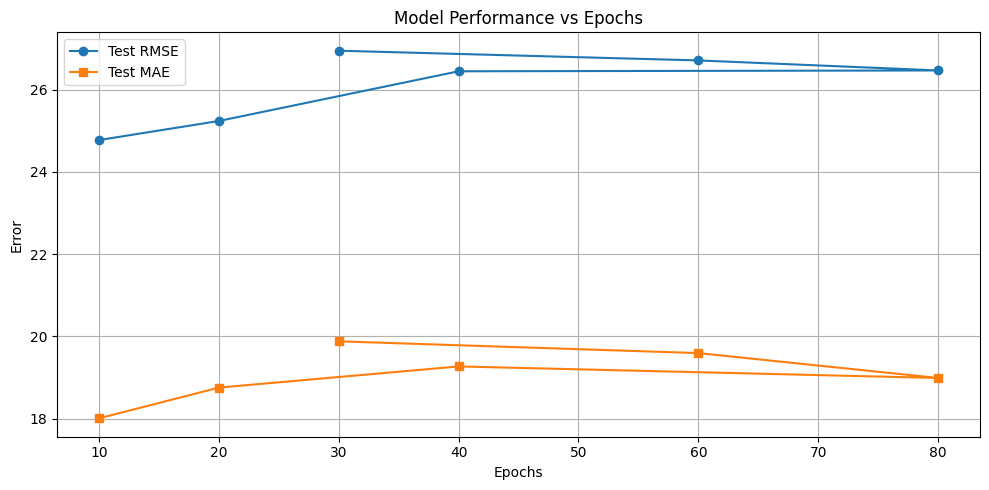

In [59]:
import matplotlib.pyplot as plt

def plot_epoch_results(df):
    plt.figure(figsize=(10, 5))
    plt.plot(df["Epochs"], df["Test_RMSE"], label="Test RMSE", marker='o')
    plt.plot(df["Epochs"], df["Test_MAE"], label="Test MAE", marker='s')
    plt.title("Model Performance vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_epoch_results(epoch_results_df)


In [64]:
## New Training Fuction

def Train_model(model, train_loader, val_loader, loss_name='mse', epochs=40, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    if loss_name == 'mse':
        criterion = nn.MSELoss()
    elif loss_name == 'huber':
        criterion = nn.HuberLoss()

    best_val_loss = float('inf')
    best_model_state = None
    val_loss_per_epoch = []

    for epoch in range(epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = model(x_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                preds = model(x_batch)
                val_loss = criterion(preds, y_batch)
                val_losses.append(val_loss.item())

        avg_val_loss = np.mean(val_losses)
        val_loss_per_epoch.append(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()

    model.load_state_dict(best_model_state)
    return model, val_loss_per_epoch


In [66]:
top_configs = [
    {"name": "ImprovedMLP_Huber_0.3", "model": ImprovedMLP, "hidden": 32, "dropout": 0.3, "loss": "huber"},
    {"name": "ImprovedMLP_MSE_0.2", "model": ImprovedMLP, "hidden": 32, "dropout": 0.2, "loss": "mse"}
]


val_curves = {}  # to store validation losses

for cfg in top_configs:
    print(f"\n⏳ Training {cfg['name']} for 100 epochs...")

    model = cfg['model'](input_dim=X_train_scaled.shape[1],
                         hidden_dim=cfg['hidden'],
                         dropout=cfg['dropout'])

    trained_model, val_losses = Train_model(model, train_loader, val_loader,
                                            loss_name=cfg['loss'], epochs=100)

    val_curves[cfg['name']] = val_losses



⏳ Training ImprovedMLP_Huber_0.3 for 100 epochs...

⏳ Training ImprovedMLP_MSE_0.2 for 100 epochs...


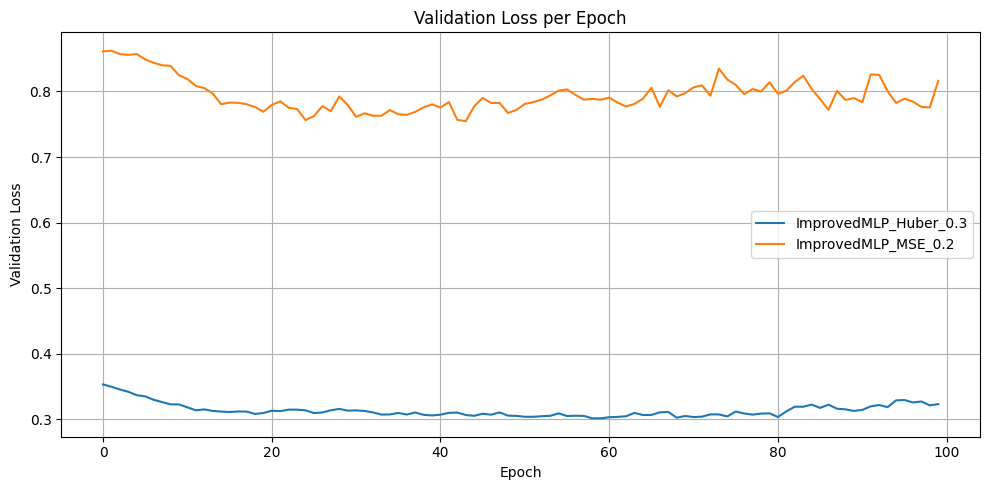

In [67]:
def plot_val_curves(val_curves):
    plt.figure(figsize=(10, 5))
    for name, losses in val_curves.items():
        plt.plot(losses, label=name)
    plt.title("Validation Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_val_curves(val_curves)


## Top 2 Models Configs

## Best MLP Model Final Training

In [ ]:
top_configs = [
    {"name": "ImprovedMLP_Huber_0.3", "model": ImprovedMLP, "hidden": 32, "dropout": 0.3, "loss": "huber"},
    {"name": "ImprovedMLP_MSE_0.2", "model": ImprovedMLP, "hidden": 32, "dropout": 0.2, "loss": "mse"}
]

long_run_results = []

for cfg in top_configs:
    print(f"\n🔁 Training {cfg['name']} for 100 epochs")

    model = cfg['model'](input_dim=X_train_scaled.shape[1],
                         hidden_dim=cfg['hidden'],
                         dropout=cfg['dropout'])

    trained_model = train_model(model, train_loader, val_loader,
                                loss_name=cfg['loss'], epochs=100)

    preds_inv, targets_inv = evaluate_model(trained_model, test_loader, y_scaler)
    rmse = mean_squared_error(targets_inv, preds_inv, squared=False)
    mae = mean_absolute_error(targets_inv, preds_inv)

    long_run_results.append({
        "Model": cfg["name"],
        "Epochs": 100,
        "Test_RMSE": rmse,
        "Test_MAE": mae
    })


In [62]:
long_run_df = pd.DataFrame(long_run_results)
display(long_run_df)


,Model,Epochs,Test_RMSE,Test_MAE
0,ImprovedMLP_Huber_0.3,100,26.946014,19.541016
1,ImprovedMLP_MSE_0.2,100,27.612673,20.795528


In [129]:
final_model = ImprovedMLP(input_dim=X_train_scaled.shape[1], hidden_dim=32, dropout=0.3)
final_model, _ = Train_model(final_model, train_loader, val_loader,
                             loss_name='huber', epochs=30)


In [130]:
preds_inv, targets_inv = evaluate_final(final_model, test_loader, y_scaler)


✅ Final Test Evaluation:
   RMSE: 25.36
   MAE : 18.42
   R²  : -0.07
   Accuracy (within ±5mm): 14.49%


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


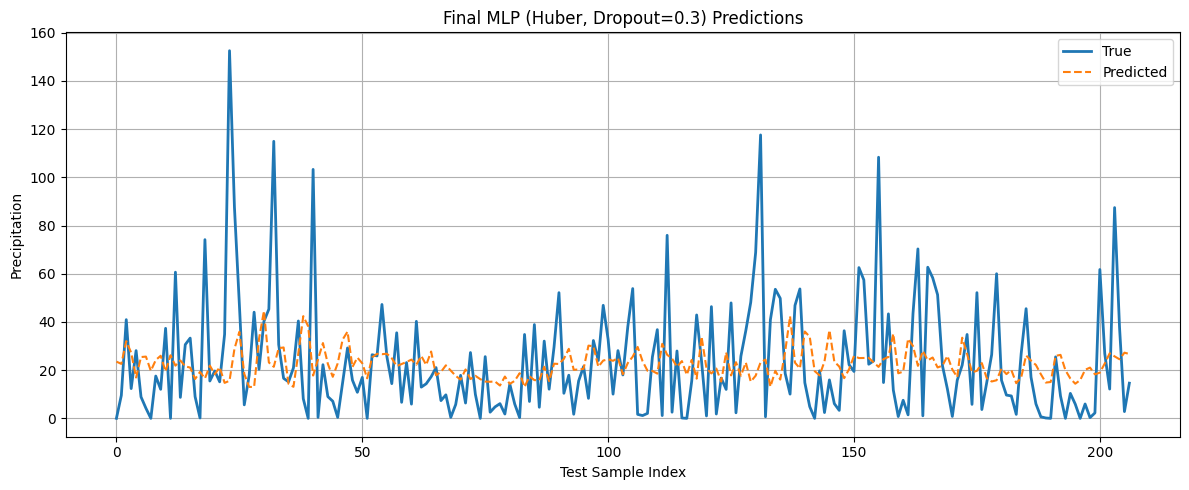

In [131]:
plot_predictions(preds_inv, targets_inv, title="Final MLP (Huber, Dropout=0.3) Predictions")


In [88]:
# Predict on val
val_preds, val_targets = evaluate_model(final_model, val_loader, y_scaler)

# Predict on test
test_preds, test_targets = evaluate_model(final_model, test_loader, y_scaler)


✅ Final Test Evaluation:
   RMSE: 19.97
   MAE : 14.49
   R²  : 0.03
   Accuracy (within ±5mm): 22.33%
✅ Final Test Evaluation:
   RMSE: 25.21
   MAE : 18.05
   R²  : -0.06
   Accuracy (within ±5mm): 15.46%


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [89]:
# Rebuild full timeline
train_targets = y_scaler.inverse_transform(y_train_scaled.reshape(-1, 1)).flatten()
val_targets = np.array(val_targets)
test_targets = np.array(test_targets)

# Predictions
train_preds = np.full_like(train_targets, np.nan)
val_preds = np.array(val_preds)
test_preds = np.array(test_preds)

# Combine
true_full = np.concatenate([train_targets, val_targets, test_targets])
pred_full = np.concatenate([train_preds, val_preds, test_preds])


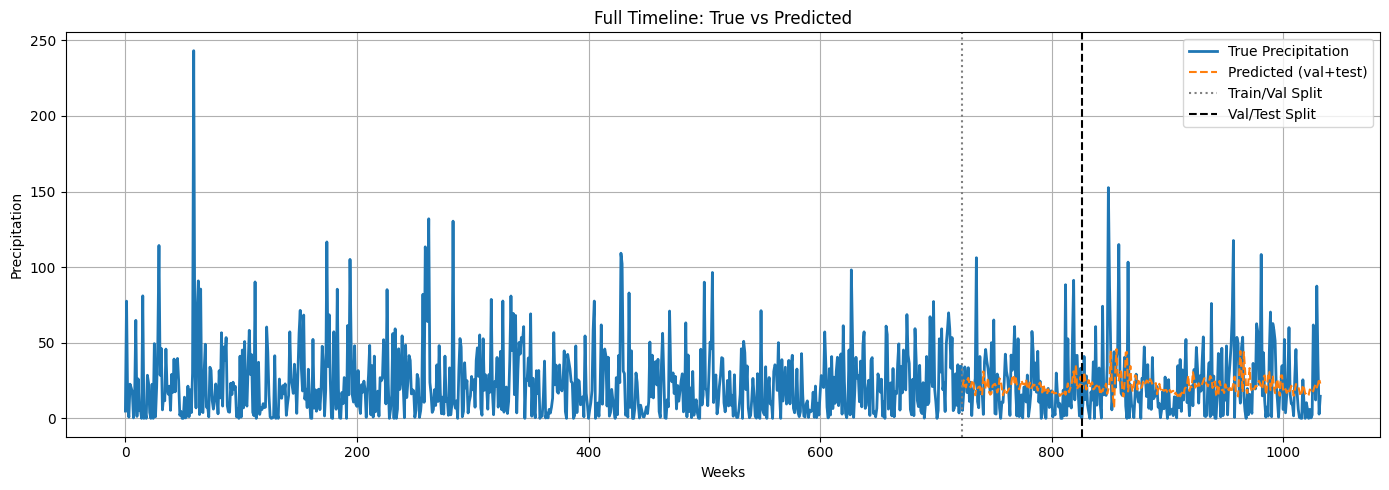

In [90]:
def plot_full_timeline(true_vals, pred_vals, split_points, title="Full Timeline: True vs Predicted"):
    plt.figure(figsize=(14, 5))
    plt.plot(true_vals, label='True Precipitation', linewidth=2)
    plt.plot(pred_vals, label='Predicted (val+test)', linestyle='--')
    
    # Split lines
    plt.axvline(x=split_points[0], color='gray', linestyle=':', label='Train/Val Split')
    plt.axvline(x=split_points[1], color='black', linestyle='--', label='Val/Test Split')

    plt.title(title)
    plt.xlabel("Weeks")
    plt.ylabel("Precipitation")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Calculate split indices
train_end = len(train_targets)
val_end = train_end + len(val_targets)

plot_full_timeline(true_full, pred_full, split_points=[train_end, val_end])


## Working on RNNS

In [51]:
df.columns

Index(['Season', 'WEEK', 'Avg_Temp_t-12', 'Avg_Temp_t-11', 'Avg_Temp_t-10',
       'Avg_Temp_t-9', 'Avg_Temp_t-8', 'Avg_Temp_t-7', 'Avg_Temp_t-6',
       'Avg_Temp_t-5', 'Avg_Temp_t-4', 'Avg_Temp_t-3', 'Avg_Temp_t-2',
       'Avg_Temp_t-1', 'Avg_Temp', 'Avg_Precip_t-12', 'Avg_Precip_t-11',
       'Avg_Precip_t-10', 'Avg_Precip_t-9', 'Avg_Precip_t-8', 'Avg_Precip_t-7',
       'Avg_Precip_t-6', 'Avg_Precip_t-5', 'Avg_Precip_t-4', 'Avg_Precip_t-3',
       'Avg_Precip_t-2', 'Avg_Precip_t-1', 'Target_Precip', 'WeekOfYear',
       'Year'],
      dtype='object')

In [97]:
def reshape_for_rnn(df):
    temp_cols = [f'Avg_Temp_t-{i}' for i in range(12, 0, -1)] 
    precip_cols = [f'Avg_Precip_t-{i}' for i in range(12, 0, -1)]

    # Stack into (n_samples, 13, 2)
    X_seq = np.stack([df[temp_cols].values, df[precip_cols].values], axis=2)
    y = df['Target_Precip'].values
    return X_seq, y


In [98]:
# X_seq, y = reshape_for_rnn(df)

# # Chronological split: 70% train · 10% val · 20% test
# n = len(X_seq)
# n_train = int(n * 0.7)
# n_val = int(n * 0.1)

# X_train, X_val, X_test = X_seq[:n_train], X_seq[n_train:n_train+n_val], X_seq[n_train+n_val:]
# y_train, y_val, y_test = y[:n_train], y[n_train:n_train+n_val], y[n_train+n_val:]

# # Standard scaling (flatten each sample first)
# x_scaler = StandardScaler().fit(X_train.reshape(-1, X_train.shape[-1]))
# y_scaler = StandardScaler().fit(y_train.reshape(-1, 1))

# X_train_scaled = x_scaler.transform(X_train.reshape(-1, 2)).reshape(X_train.shape)
# X_val_scaled = x_scaler.transform(X_val.reshape(-1, 2)).reshape(X_val.shape)
# X_test_scaled = x_scaler.transform(X_test.reshape(-1, 2)).reshape(X_test.shape)

# y_train_scaled = y_scaler.transform(y_train.reshape(-1, 1)).flatten()
# y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1)).flatten()
# y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()


In [138]:
# train_ds = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32),
#                          torch.tensor(y_train_scaled, dtype=torch.float32))
# val_ds = TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32),
#                        torch.tensor(y_val_scaled, dtype=torch.float32))
# test_ds = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32),
#                         torch.tensor(y_test_scaled, dtype=torch.float32))

# train_loader = DataLoader(train_ds, batch_size=32, shuffle=False)
# val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)


# --- Sequence preparation ----------------------------------------------------
ar_X_seq, ar_y = reshape_for_rnn(df)   # inputs & targets for AR model

# --- Chronological split: 70 % train · 10 % val · 20 % test ---------------
n          = len(ar_X_seq)
n_train    = int(n * 0.7)
n_val      = int(n * 0.1)

ar_X_train, ar_X_val, ar_X_test = (
    ar_X_seq[:n_train],
    ar_X_seq[n_train:n_train + n_val],
    ar_X_seq[n_train + n_val:]
)
ar_y_train, ar_y_val, ar_y_test = (
    ar_y[:n_train],
    ar_y[n_train:n_train + n_val],
    ar_y[n_train + n_val:]
)

# --- Standard scaling --------------------------------------------------------
ar_x_scaler = StandardScaler().fit(ar_X_train.reshape(-1, ar_X_train.shape[-1]))
ar_y_scaler = StandardScaler().fit(ar_y_train.reshape(-1, 1))

ar_X_train_scaled = ar_x_scaler.transform(ar_X_train.reshape(-1, 2)).reshape(ar_X_train.shape)
ar_X_val_scaled   = ar_x_scaler.transform(ar_X_val.reshape(-1, 2)).reshape(ar_X_val.shape)
ar_X_test_scaled  = ar_x_scaler.transform(ar_X_test.reshape(-1, 2)).reshape(ar_X_test.shape)

ar_y_train_scaled = ar_y_scaler.transform(ar_y_train.reshape(-1, 1)).flatten()
ar_y_val_scaled   = ar_y_scaler.transform(ar_y_val.reshape(-1, 1)).flatten()
ar_y_test_scaled  = ar_y_scaler.transform(ar_y_test.reshape(-1, 1)).flatten()

# --- TensorDatasets ----------------------------------------------------------
ar_train_ds = TensorDataset(torch.tensor(ar_X_train_scaled, dtype=torch.float32),
                            torch.tensor(ar_y_train_scaled, dtype=torch.float32))
ar_val_ds   = TensorDataset(torch.tensor(ar_X_val_scaled,   dtype=torch.float32),
                            torch.tensor(ar_y_val_scaled,   dtype=torch.float32))
ar_test_ds  = TensorDataset(torch.tensor(ar_X_test_scaled,  dtype=torch.float32),
                            torch.tensor(ar_y_test_scaled,  dtype=torch.float32))

# --- DataLoaders -------------------------------------------------------------
ar_train_loader = DataLoader(ar_train_ds, batch_size=32, shuffle=False)
ar_val_loader   = DataLoader(ar_val_ds,   batch_size=32, shuffle=False)
ar_test_loader  = DataLoader(ar_test_ds,  batch_size=32, shuffle=False)



In [ ]:
# train_ds[0]

In [ ]:
# list(train_loader)

In [155]:
## Simple RNN

# class SimpleRNN(nn.Module):
#     def __init__(self, input_size=2, hidden_size=64, dropout=0.3):
#         super(SimpleRNN, self).__init__()
#         self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size,
#                           batch_first=True, dropout=dropout, nonlinearity='relu')
#         self.fc = nn.Linear(hidden_size, 1)

#     def forward(self, x):
#         out, _ = self.rnn(x)  # out: (batch, seq, hidden)
#         last_out = out[:, -1, :]  # take output at last timestep
#         return self.fc(last_out).squeeze(1)
class SimpleRNN(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, dropout=0.3):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size,
                          batch_first=True,
                          nonlinearity='relu')   # no between‑layer dropout
        self.do  = nn.Dropout(dropout)           # <-- key line
        self.fc  = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _  = self.rnn(x)        # (B, T, H)
        h_last  = self.do(out[:, -1, :])
        return self.fc(h_last).squeeze(1)

In [148]:
# class GRUModel(nn.Module):
#     def __init__(self, input_size=2, hidden_size=64, dropout=0.3):
#         super(GRUModel, self).__init__()
#         self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,
#                           batch_first=True, dropout=dropout)
#         self.fc = nn.Linear(hidden_size, 1)
        
#     def forward(self, x):
#         out, _ = self.gru(x)  # out: (batch, seq, hidden)
#         last_out = out[:, -1, :]  # take output at last timestep
#         return self.fc(last_out).squeeze(1)

class GRUModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, dropout=0.3):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True,
                          dropout=dropout)
        self.do  = nn.Dropout(dropout)
        self.fc  = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        h_last = self.do(out[:, -1, :])
        return self.fc(h_last).squeeze(1)

In [150]:
# class TimeSeriesLSTM(nn.Module):
#     def __init__(self, input_size=2, hidden_size=64, num_layers=2, dropout=0.3):
#         super(TimeSeriesLSTM, self).__init__()
#         self.lstm = nn.LSTM(input_size=input_size, 
#                            hidden_size=hidden_size,
#                            num_layers=num_layers,
#                            batch_first=True, 
#                            dropout=dropout if num_layers > 1 else 0)
#         self.fc = nn.Linear(hidden_size, 1)
        
#     def forward(self, x):
#         out, _ = self.lstm(x)
#         last_out = out[:, -1, :]
#         return self.fc(last_out).squeeze(1)

class TimeSeriesLSTM(nn.Module):
    def __init__(self, input_size=2, hidden_size=64,
                 num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout if num_layers > 1 else 0.)
        self.do   = nn.Dropout(dropout)
        self.fc   = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        h_last = self.do(out[:, -1, :])
        return self.fc(h_last).squeeze(1)

/usr/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


✅ Final Test Evaluation:
   RMSE: 26.63
   MAE : 19.41
   R²  : -0.18
   Accuracy (within ±5mm): 13.53%


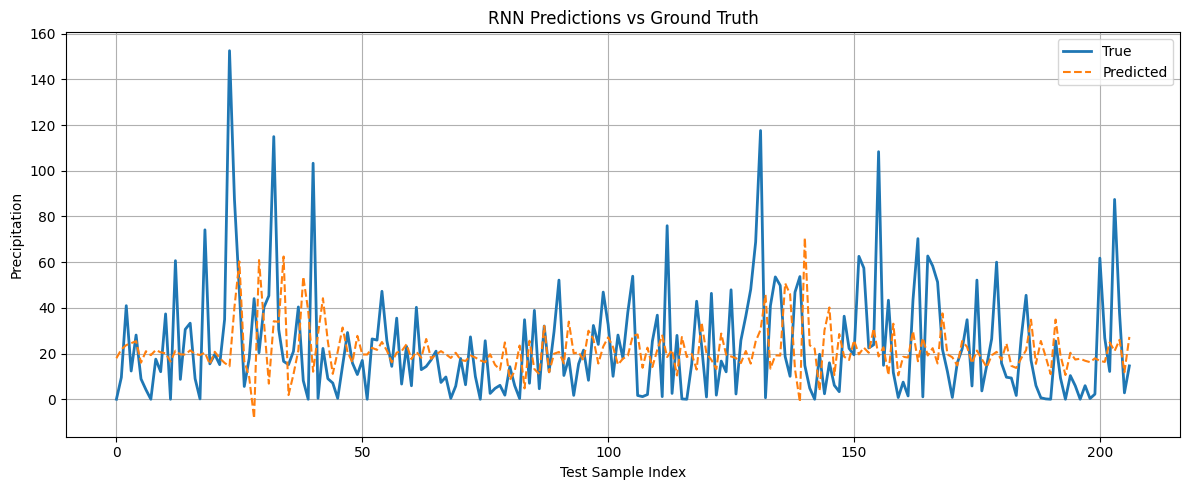

In [163]:
rnn_model = SimpleRNN(input_size=2, hidden_size=64, dropout=0.3)
trained_rnn, _ = Train_model(rnn_model, ar_train_loader, ar_val_loader, loss_name='huber', epochs=30)

# Evaluate + Plot
rnn_preds, rnn_targets = evaluate_model(trained_rnn, ar_test_loader, ar_y_scaler)
plot_predictions(rnn_preds, rnn_targets, title="RNN Predictions vs Ground Truth")


/usr/local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


✅ Final Test Evaluation:
   RMSE: 24.65
   MAE : 17.25
   R²  : -0.01
   Accuracy (within ±5mm): 19.81%


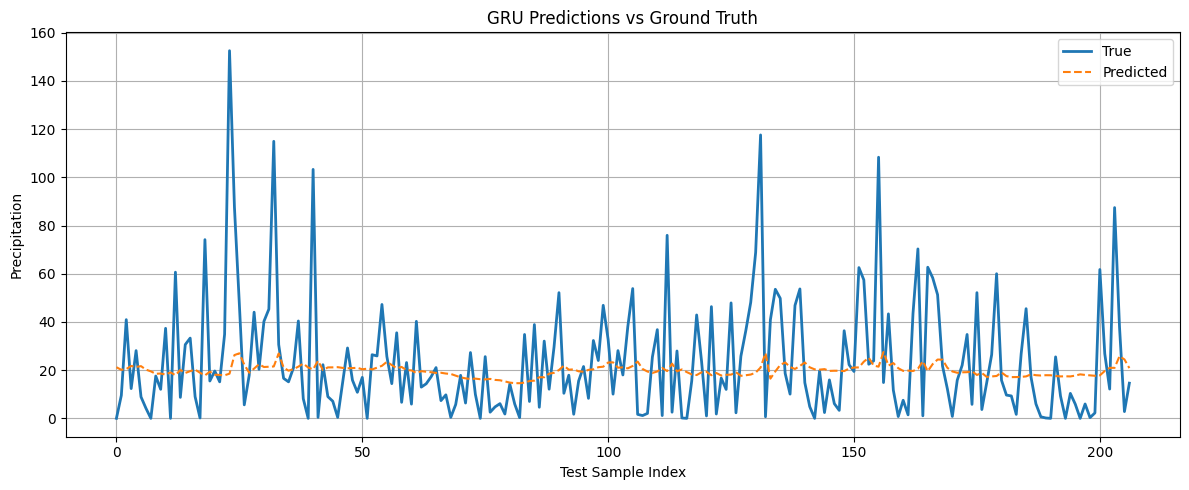

In [164]:
gru_model = GRUModel(input_size=2, hidden_size=64, dropout=0.3)
trained_GRU, _ = Train_model(gru_model, ar_train_loader, ar_val_loader, loss_name='huber', epochs=30)

# Evaluate + Plot
gru_preds, gru_targets = evaluate_model(trained_GRU, ar_test_loader, ar_y_scaler)
plot_predictions(gru_preds, gru_targets, title="GRU Predictions vs Ground Truth")


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


✅ Final Test Evaluation:
   RMSE: 24.63
   MAE : 17.24
   R²  : -0.01
   Accuracy (within ±5mm): 17.39%


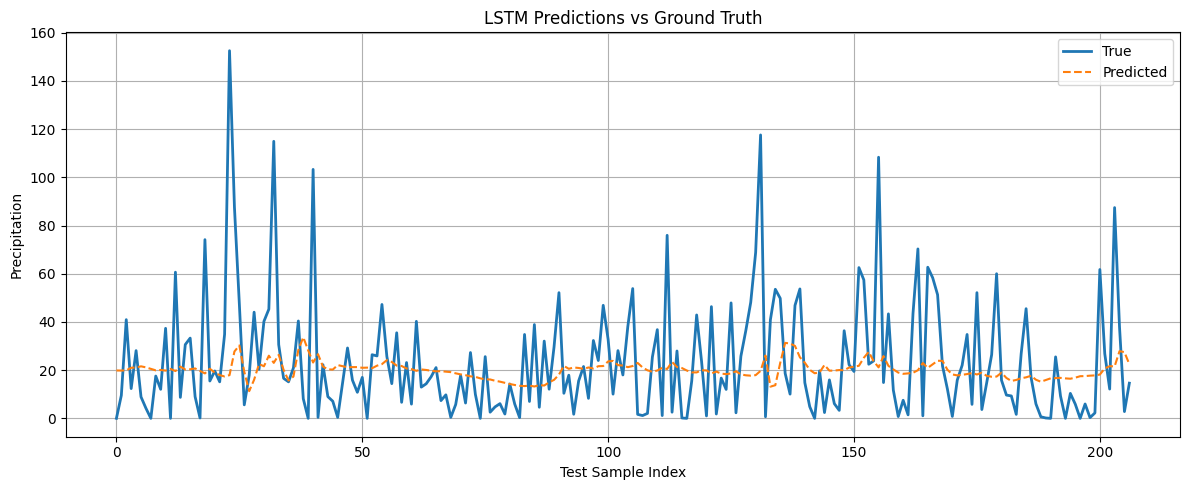

In [165]:
# Define the LSTM model
lstm_model = TimeSeriesLSTM(input_size=2, hidden_size=64, num_layers=2, dropout=0.3)

# Train the model
trained_lstm, _ = Train_model(lstm_model, ar_train_loader, ar_val_loader, loss_name='huber', epochs=30)

# Evaluate the model
lstm_preds, lstm_targets = evaluate_model(trained_lstm, ar_test_loader, ar_y_scaler)

# Plot the results
plot_predictions(lstm_preds, lstm_targets, title="LSTM Predictions vs Ground Truth")

## Test on Dropout

In [132]:
import torch
import numpy as np
from scipy.stats import norm

def mc_dropout_predict(model, dataloader, y_scaler, T=100, dropout=True, device='cpu'):
    model.train() if dropout else model.eval()  # Keep dropout active
    model = model.to(device)

    all_preds = []

    for t in range(T):
        preds = []
        with torch.no_grad():
            for x_batch, _ in dataloader:
                x_batch = x_batch.to(device)
                pred = model(x_batch).cpu().numpy()
                preds.append(pred)
        preds = np.concatenate(preds).flatten()
        all_preds.append(preds)

    # Convert to (T, N)
    all_preds = np.stack(all_preds)

    # Inverse transform predictions
    all_preds_inv = y_scaler.inverse_transform(all_preds.T).T

    pred_mean = np.mean(all_preds_inv, axis=0)
    pred_std = np.std(all_preds_inv, axis=0)

    return pred_mean, pred_std, all_preds_inv


In [133]:
def compute_coverage(pred_mean, pred_std, targets, alpha=0.95):
    z = norm.ppf(0.5 + alpha / 2)  # e.g., z=1.96 for 95%
    lower = pred_mean - z * pred_std
    upper = pred_mean + z * pred_std
    covered = (targets >= lower) & (targets <= upper)
    return np.mean(covered)


In [134]:
def nll_gaussian(pred_mean, pred_std, targets):
    var = pred_std ** 2 + 1e-6  # avoid log(0)
    return 0.5 * np.mean(np.log(2 * np.pi * var) + ((targets - pred_mean) ** 2) / var)


In [135]:
# Evaluate on test set
mc_mean, mc_std, mc_samples = mc_dropout_predict(final_model, test_loader, y_scaler, T=100)

# Get targets
_, targets_inv = evaluate_model(final_model, test_loader, y_scaler)

# Metrics
nll = nll_gaussian(mc_mean, mc_std, targets_inv)
coverage_80 = compute_coverage(mc_mean, mc_std, targets_inv, alpha=0.80)
coverage_95 = compute_coverage(mc_mean, mc_std, targets_inv, alpha=0.95)

print(f"NLL: {nll:.3f}")
print(f"80% Coverage: {coverage_80*100:.2f}%")
print(f"95% Coverage: {coverage_95*100:.2f}%")


✅ Final Test Evaluation:
   RMSE: 25.40
   MAE : 17.92
   R²  : -0.07
   Accuracy (within ±5mm): 15.46%
NLL: 69.087
80% Coverage: 15.46%
95% Coverage: 21.74%


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [136]:
import matplotlib.pyplot as plt

def plot_uncertainty(pred_mean, pred_std, targets, title="MC Dropout Uncertainty", alpha=0.95):
    z = 1.96 if alpha == 0.95 else 1.28  # 1.96 for 95%, 1.28 for 80%
    lower = pred_mean - z * pred_std
    upper = pred_mean + z * pred_std

    plt.figure(figsize=(14, 6))

    # Plot true values
    plt.plot(targets, label="True", color='steelblue', linewidth=1.5)

    # Plot predictive mean
    plt.plot(pred_mean, label="Predicted Mean", color='darkorange', linestyle='--', linewidth=2)

    # Shaded uncertainty area
    plt.fill_between(range(len(pred_mean)), lower, upper, color='orange', alpha=0.25, label=f"{int(alpha*100)}% CI")

    plt.xlabel("Test Sample Index")
    plt.ylabel("Precipitation")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


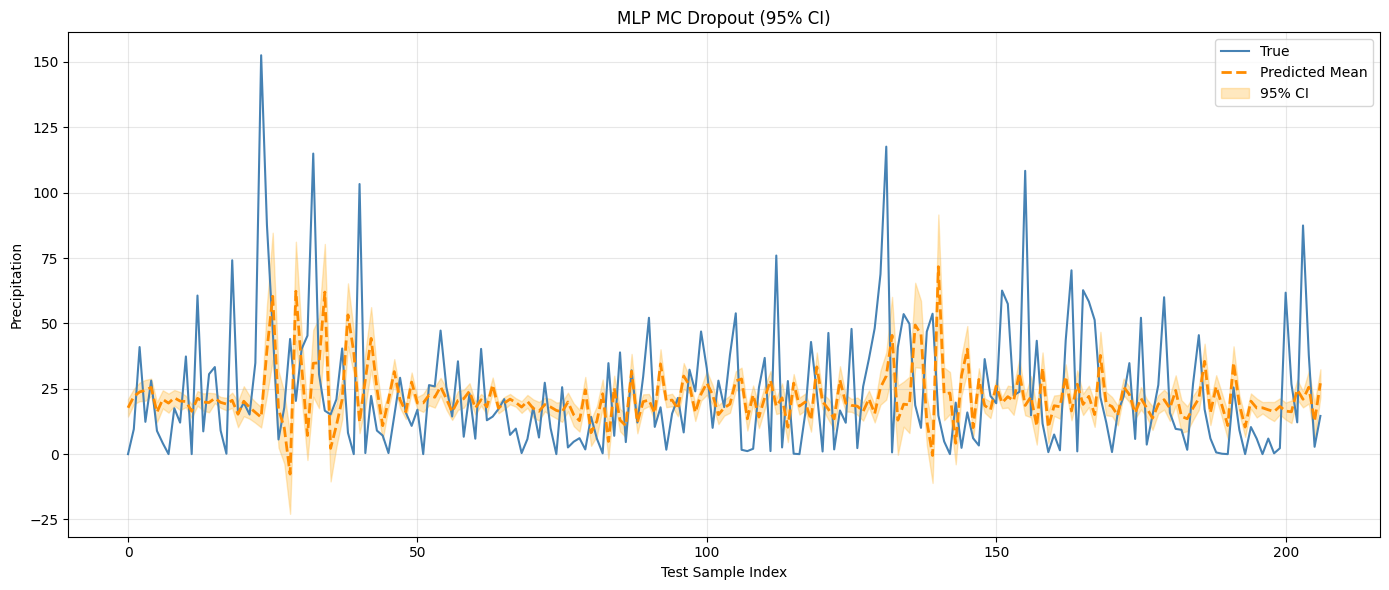

In [253]:
plot_uncertainty(mc_mean, mc_std, targets_inv, title="MLP MC Dropout (95% CI)", alpha=0.95)


In [166]:
## Evaluation for RNN
mc_mean, mc_std, mc_samples = mc_dropout_predict(
    trained_rnn,        # <- new model with explicit dropout
    ar_test_loader,     # shape: (B, seq_len, 2)  ✅
    ar_y_scaler,
    T=100,              # number of stochastic passes
    dropout=True    # or 'cpu'
)

# Ground‑truth (already inverse‑scaled inside evaluate_model)
_, targets_inv = evaluate_model(trained_rnn, ar_test_loader, ar_y_scaler)



✅ Final Test Evaluation:
   RMSE: 26.63
   MAE : 19.41
   R²  : -0.18
   Accuracy (within ±5mm): 13.53%


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


✅ Final Test Evaluation:
   RMSE: 26.63
   MAE : 19.41
   R²  : -0.18
   Accuracy (within ±5mm): 13.53%
NLL: 76.837
80 % coverage: 9.18%
95 % coverage: 13.04%


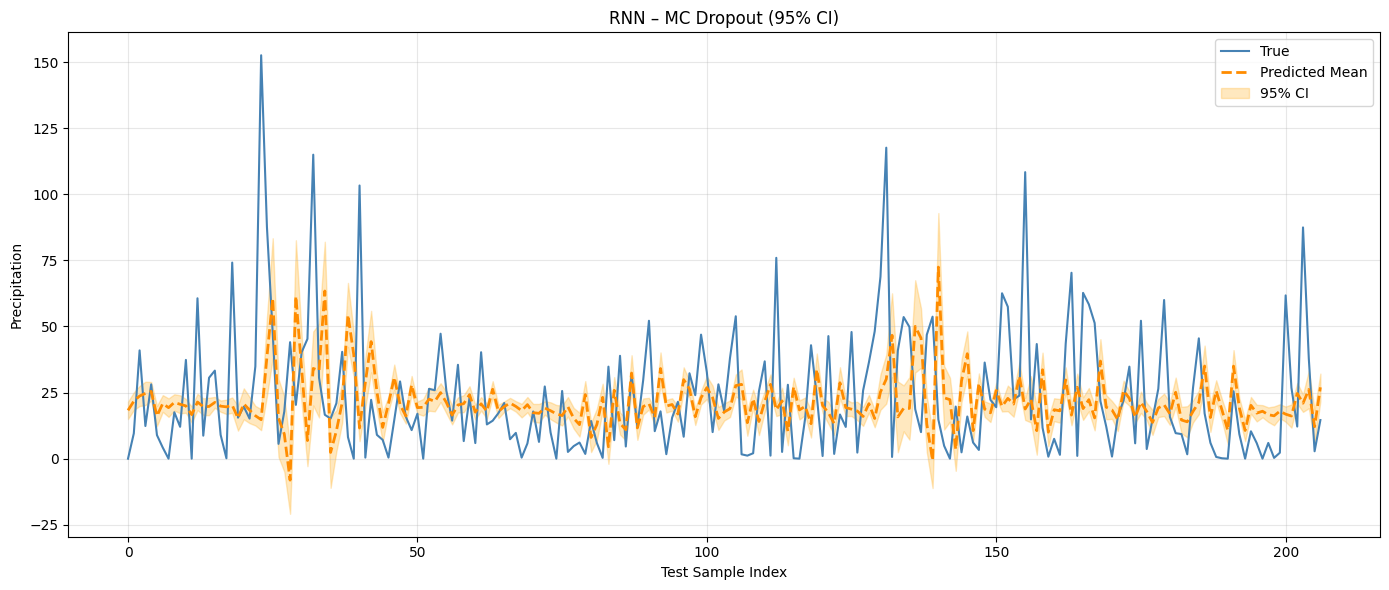

In [255]:
## Evaluation for RNN
mc_mean, mc_std, mc_samples = mc_dropout_predict(
    trained_rnn,        # <- new model with explicit dropout
    ar_test_loader,     # shape: (B, seq_len, 2)  ✅
    ar_y_scaler,
    T=100,              # number of stochastic passes
    dropout=True    # or 'cpu'
)

# Ground‑truth (already inverse‑scaled inside evaluate_model)
_, targets_inv = evaluate_model(trained_rnn, ar_test_loader, ar_y_scaler)


nll     = nll_gaussian(mc_mean, mc_std, targets_inv)
cov80   = compute_coverage(mc_mean, mc_std, targets_inv, alpha=0.80)
cov95   = compute_coverage(mc_mean, mc_std, targets_inv, alpha=0.95)

print(f"NLL: {nll:.3f}")
print(f"80 % coverage: {cov80*100:.2f}%")
print(f"95 % coverage: {cov95*100:.2f}%")

plot_uncertainty(mc_mean, mc_std, targets_inv,
                 title="RNN – MC Dropout (95% CI)")


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


✅ Final Test Evaluation:
   RMSE: 24.65
   MAE : 17.25
   R²  : -0.01
   Accuracy (within ±5mm): 19.81%
[GRU]   NLL: 308.505
[GRU]  80% coverage: 3.38%
[GRU]  95% coverage: 5.31%


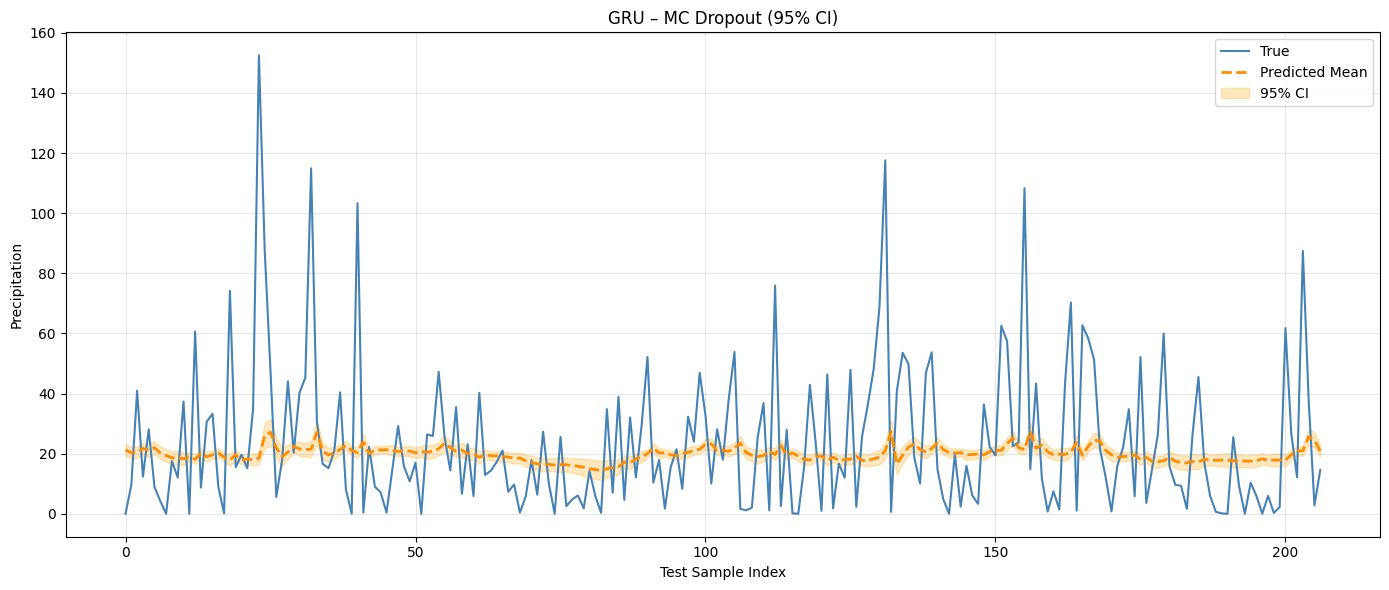

In [168]:
mc_mean_gru, mc_std_gru, mc_samples_gru = mc_dropout_predict(
    trained_GRU,        # <- your trained GRUModel with explicit dropout
    ar_test_loader,
    ar_y_scaler,
    T=100,
    dropout=True
)

_, targets_inv_gru = evaluate_model(trained_GRU, ar_test_loader, ar_y_scaler)

nll_gru   = nll_gaussian(mc_mean_gru, mc_std_gru, targets_inv_gru)
cov80_gru = compute_coverage(mc_mean_gru, mc_std_gru, targets_inv_gru, alpha=0.80)
cov95_gru = compute_coverage(mc_mean_gru, mc_std_gru, targets_inv_gru, alpha=0.95)

print(f"[GRU]   NLL: {nll_gru:.3f}")
print(f"[GRU]  80% coverage: {cov80_gru * 100:.2f}%")
print(f"[GRU]  95% coverage: {cov95_gru * 100:.2f}%")

plot_uncertainty(mc_mean_gru, mc_std_gru, targets_inv_gru,
                 title="GRU – MC Dropout (95% CI)")


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


✅ Final Test Evaluation:
   RMSE: 24.63
   MAE : 17.24
   R²  : -0.01
   Accuracy (within ±5mm): 17.39%
[LSTM]  NLL: 649.378
[LSTM] 80% coverage: 3.86%
[LSTM] 95% coverage: 5.80%


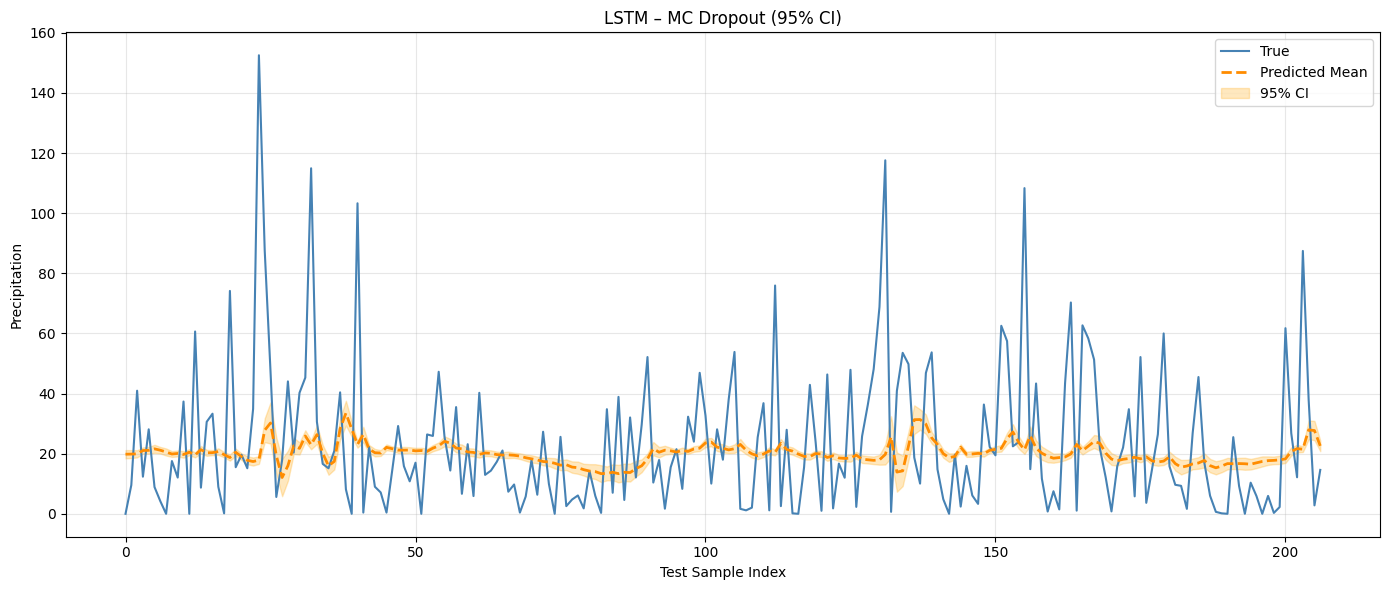

In [169]:
mc_mean_lstm, mc_std_lstm, mc_samples_lstm = mc_dropout_predict(
    trained_lstm,       # <- your trained LSTM with explicit dropout
    ar_test_loader,
    ar_y_scaler,
    T=100,
    dropout=True
)

_, targets_inv_lstm = evaluate_model(trained_lstm, ar_test_loader, ar_y_scaler)

nll_lstm   = nll_gaussian(mc_mean_lstm, mc_std_lstm, targets_inv_lstm)
cov80_lstm = compute_coverage(mc_mean_lstm, mc_std_lstm, targets_inv_lstm, alpha=0.80)
cov95_lstm = compute_coverage(mc_mean_lstm, mc_std_lstm, targets_inv_lstm, alpha=0.95)

print(f"[LSTM]  NLL: {nll_lstm:.3f}")
print(f"[LSTM] 80% coverage: {cov80_lstm * 100:.2f}%")
print(f"[LSTM] 95% coverage: {cov95_lstm * 100:.2f}%")

plot_uncertainty(mc_mean_lstm, mc_std_lstm, targets_inv_lstm,
                 title="LSTM – MC Dropout (95% CI)")


## Bayesian NN

In [170]:
X_train.shape

(723, 28)

In [171]:
ar_X_train.shape

(723, 12, 2)

In [172]:
!pip install torchbnn



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [173]:
import torch.nn as nn
import torchbnn as bnn

In [237]:
class BayesianMLP(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64):
        super().__init__()
        self.bfc1 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1,
                                    in_features=input_dim, out_features=hidden_dim)
        self.bfc2 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1,
                                    in_features=hidden_dim, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bfc1(x))
        return self.bfc2(x).squeeze(1)

In [238]:
def elbo_loss(output, target, model, criterion, kl_weight=0.01):
    likelihood = criterion(output, target)
    kl = bnn.BKLLoss(reduction='mean', last_layer_only=False)(model)
    return likelihood + kl_weight * kl

In [239]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BayesianMLP(input_dim=28, hidden_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# criterion = nn.MSELoss()  # or nn.HuberLoss()
criterion = nn.HuberLoss(delta=1.0)

num_epochs = 100
kl_weight = 0.01  # you can tune this

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        preds = model(xb)
        loss = elbo_loss(preds, yb, model, criterion, kl_weight=0.1)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1:02d} | Train Loss: {total_loss:.4f}")

Epoch 01 | Train Loss: 11.7664
Epoch 02 | Train Loss: 11.4325
Epoch 03 | Train Loss: 11.0555
Epoch 04 | Train Loss: 11.4127
Epoch 05 | Train Loss: 11.1127
Epoch 06 | Train Loss: 10.4012
Epoch 07 | Train Loss: 11.0141
Epoch 08 | Train Loss: 10.2044
Epoch 09 | Train Loss: 11.0592
Epoch 10 | Train Loss: 10.2605
Epoch 11 | Train Loss: 9.8675
Epoch 12 | Train Loss: 10.6815
Epoch 13 | Train Loss: 9.9123
Epoch 14 | Train Loss: 10.2017
Epoch 15 | Train Loss: 10.6203
Epoch 16 | Train Loss: 10.4839
Epoch 17 | Train Loss: 10.0102
Epoch 18 | Train Loss: 9.7444
Epoch 19 | Train Loss: 9.8705
Epoch 20 | Train Loss: 10.1275
Epoch 21 | Train Loss: 9.3646
Epoch 22 | Train Loss: 9.8856
Epoch 23 | Train Loss: 9.9298
Epoch 24 | Train Loss: 9.5440
Epoch 25 | Train Loss: 9.7053
Epoch 26 | Train Loss: 9.5134
Epoch 27 | Train Loss: 9.5048
Epoch 28 | Train Loss: 9.6366
Epoch 29 | Train Loss: 9.3492
Epoch 30 | Train Loss: 9.3918
Epoch 31 | Train Loss: 9.1413
Epoch 32 | Train Loss: 9.3017
Epoch 33 | Train Loss: 9

In [240]:
best_val_loss = float('inf')
patience = 10
counter = 0

for epoch in range(num_epochs):
    ...
    # Evaluate on val_loader
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            val_loss += criterion(preds, yb).item()

    print(f"Epoch {epoch+1:02d} | Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_bnn.pt")  # Save best model
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping.")
            break


Epoch 01 | Train Loss: 8.2543 | Val Loss: 1.2784
Epoch 02 | Train Loss: 8.2543 | Val Loss: 1.3741
Epoch 03 | Train Loss: 8.2543 | Val Loss: 1.2912
Epoch 04 | Train Loss: 8.2543 | Val Loss: 1.3180
Epoch 05 | Train Loss: 8.2543 | Val Loss: 1.2313
Epoch 06 | Train Loss: 8.2543 | Val Loss: 1.2442
Epoch 07 | Train Loss: 8.2543 | Val Loss: 1.1851
Epoch 08 | Train Loss: 8.2543 | Val Loss: 1.4080
Epoch 09 | Train Loss: 8.2543 | Val Loss: 1.4681
Epoch 10 | Train Loss: 8.2543 | Val Loss: 1.5029
Epoch 11 | Train Loss: 8.2543 | Val Loss: 1.2614
Epoch 12 | Train Loss: 8.2543 | Val Loss: 1.3610
Epoch 13 | Train Loss: 8.2543 | Val Loss: 1.3391
Epoch 14 | Train Loss: 8.2543 | Val Loss: 1.3773
Epoch 15 | Train Loss: 8.2543 | Val Loss: 1.2715
Epoch 16 | Train Loss: 8.2543 | Val Loss: 1.4201
Epoch 17 | Train Loss: 8.2543 | Val Loss: 1.2116
Early stopping.


In [241]:
def bayesian_predict(model, dataloader, y_scaler, T=100, device='cpu'):
    model.train()  # keep sampling enabled
    all_preds = []

    for _ in range(T):
        preds = []
        with torch.no_grad():
            for x_batch, _ in dataloader:
                x_batch = x_batch.to(device)
                pred = model(x_batch).cpu().numpy()
                preds.append(pred)
        all_preds.append(np.concatenate(preds).flatten())

    all_preds = np.stack(all_preds)  # (T, N)
    all_preds_inv = y_scaler.inverse_transform(all_preds.T).T

    pred_mean = np.mean(all_preds_inv, axis=0)
    pred_std = np.std(all_preds_inv, axis=0)
    return pred_mean, pred_std, all_preds_inv


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


✅ Final Test Evaluation:
   RMSE: 25.43
   MAE : 18.41
   R²  : -0.07
   Accuracy (within ±5mm): 15.46%
[BNN]   NLL: 11.174
[BNN]  80% coverage: 24.15%
[BNN]  95% coverage: 40.10%


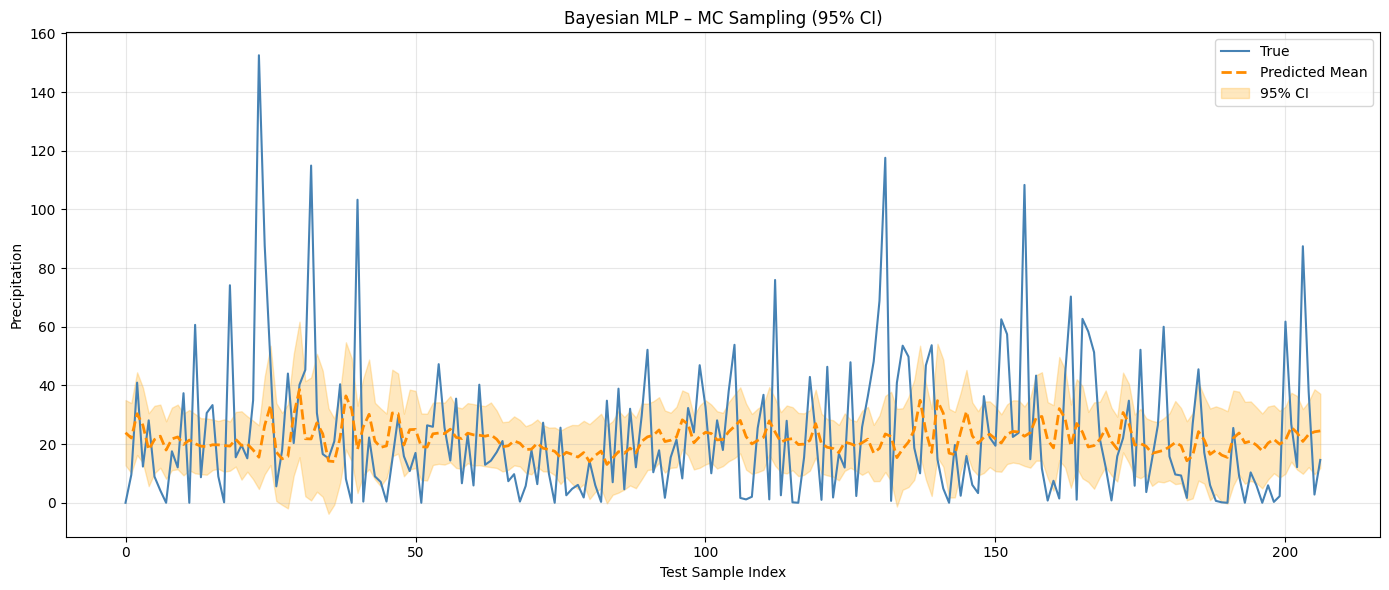

In [242]:
# Predict
mc_mean_bnn, mc_std_bnn, mc_samples_bnn = bayesian_predict(
    model, test_loader, y_scaler, T=200, device=device)

# Get ground truth
_, targets_inv_bnn = evaluate_model(model, test_loader, y_scaler)

# Metrics
nll_bnn    = nll_gaussian(mc_mean_bnn, mc_std_bnn, targets_inv_bnn)
cov80_bnn  = compute_coverage(mc_mean_bnn, mc_std_bnn, targets_inv_bnn, alpha=0.80)
cov95_bnn  = compute_coverage(mc_mean_bnn, mc_std_bnn, targets_inv_bnn, alpha=0.95)

print(f"[BNN]   NLL: {nll_bnn:.3f}")
print(f"[BNN]  80% coverage: {cov80_bnn * 100:.2f}%")
print(f"[BNN]  95% coverage: {cov95_bnn * 100:.2f}%")

# Plot
plot_uncertainty(mc_mean_bnn, mc_std_bnn, targets_inv_bnn,
                 title="Bayesian MLP – MC Sampling (95% CI)")


In [243]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BayesianMLP(input_dim=28, hidden_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()  # or nn.HuberLoss()
# criterion = nn.HuberLoss(delta=1.0)

num_epochs = 100
kl_weight = 0.01  # you can tune this

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        preds = model(xb)
        loss = elbo_loss(preds, yb, model, criterion, kl_weight=0.05)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1:02d} | Train Loss: {total_loss:.4f}")

Epoch 01 | Train Loss: 31.1231
Epoch 02 | Train Loss: 28.9443
Epoch 03 | Train Loss: 31.3511
Epoch 04 | Train Loss: 29.5088
Epoch 05 | Train Loss: 27.1276
Epoch 06 | Train Loss: 27.4574
Epoch 07 | Train Loss: 27.4197
Epoch 08 | Train Loss: 27.8454
Epoch 09 | Train Loss: 27.4035
Epoch 10 | Train Loss: 26.9272
Epoch 11 | Train Loss: 25.5488
Epoch 12 | Train Loss: 26.0997
Epoch 13 | Train Loss: 25.4581
Epoch 14 | Train Loss: 26.8365
Epoch 15 | Train Loss: 27.2110
Epoch 16 | Train Loss: 26.0584
Epoch 17 | Train Loss: 24.9917
Epoch 18 | Train Loss: 26.9657
Epoch 19 | Train Loss: 26.1905
Epoch 20 | Train Loss: 25.7674
Epoch 21 | Train Loss: 25.9902
Epoch 22 | Train Loss: 25.4758
Epoch 23 | Train Loss: 24.7009
Epoch 24 | Train Loss: 25.1725
Epoch 25 | Train Loss: 25.0745
Epoch 26 | Train Loss: 25.2832
Epoch 27 | Train Loss: 25.0557
Epoch 28 | Train Loss: 23.8859
Epoch 29 | Train Loss: 24.4888
Epoch 30 | Train Loss: 24.1278
Epoch 31 | Train Loss: 25.7579
Epoch 32 | Train Loss: 24.3368
Epoch 33

In [244]:
best_val_loss = float('inf')
patience = 10
counter = 0

for epoch in range(num_epochs):
    ...
    # Evaluate on val_loader
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            val_loss += criterion(preds, yb).item()

    print(f"Epoch {epoch+1:02d} | Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_bnn.pt")  # Save best model
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping.")
            break


Epoch 01 | Train Loss: 22.8284 | Val Loss: 3.1579
Epoch 02 | Train Loss: 22.8284 | Val Loss: 3.3036
Epoch 03 | Train Loss: 22.8284 | Val Loss: 3.3406
Epoch 04 | Train Loss: 22.8284 | Val Loss: 3.1323
Epoch 05 | Train Loss: 22.8284 | Val Loss: 3.2828
Epoch 06 | Train Loss: 22.8284 | Val Loss: 3.3369
Epoch 07 | Train Loss: 22.8284 | Val Loss: 4.2431
Epoch 08 | Train Loss: 22.8284 | Val Loss: 3.2848
Epoch 09 | Train Loss: 22.8284 | Val Loss: 3.1260
Epoch 10 | Train Loss: 22.8284 | Val Loss: 3.4023
Epoch 11 | Train Loss: 22.8284 | Val Loss: 3.2203
Epoch 12 | Train Loss: 22.8284 | Val Loss: 3.2882
Epoch 13 | Train Loss: 22.8284 | Val Loss: 3.6089
Epoch 14 | Train Loss: 22.8284 | Val Loss: 3.1038
Epoch 15 | Train Loss: 22.8284 | Val Loss: 4.1730
Epoch 16 | Train Loss: 22.8284 | Val Loss: 3.3747
Epoch 17 | Train Loss: 22.8284 | Val Loss: 3.6213
Epoch 18 | Train Loss: 22.8284 | Val Loss: 3.3713
Epoch 19 | Train Loss: 22.8284 | Val Loss: 3.6348
Epoch 20 | Train Loss: 22.8284 | Val Loss: 3.6864


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


✅ Final Test Evaluation:
   RMSE: 25.33
   MAE : 17.97
   R²  : -0.07
   Accuracy (within ±5mm): 19.32%
[BNN]   NLL: 8.998
[BNN]  80% coverage: 33.33%
[BNN]  95% coverage: 52.17%


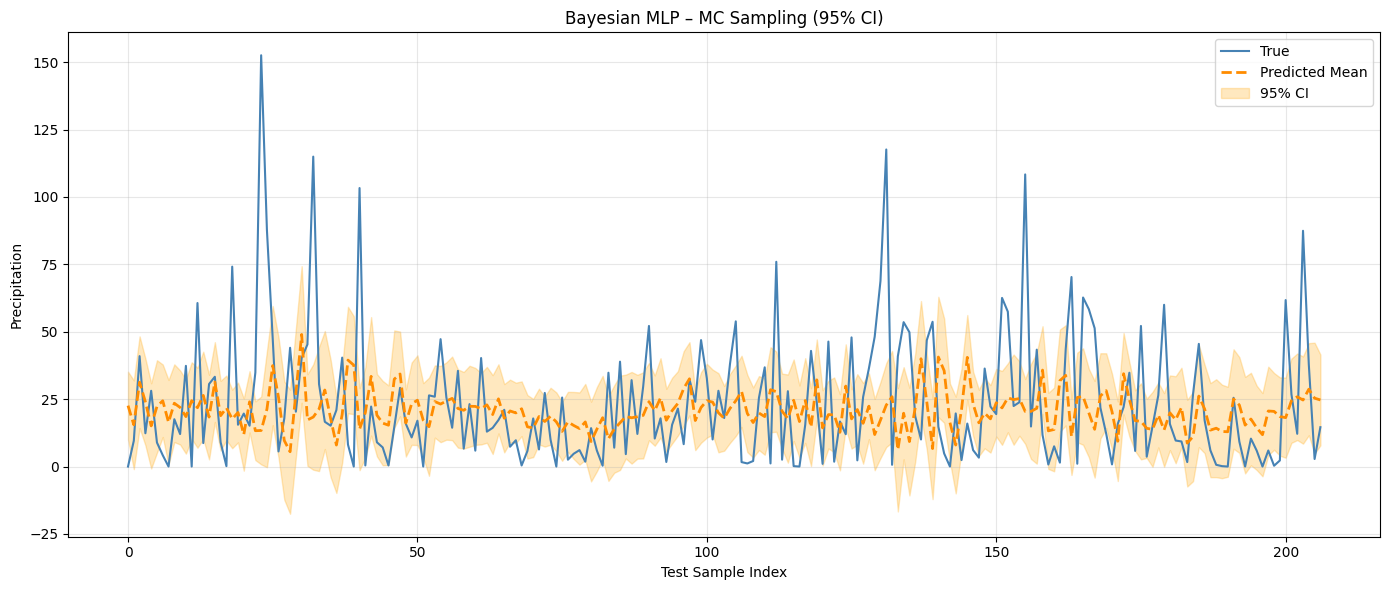

In [245]:
# Predict
mc_mean_bnn, mc_std_bnn, mc_samples_bnn = bayesian_predict(
    model, test_loader, y_scaler, T=200, device=device)

# Get ground truth
_, targets_inv_bnn = evaluate_model(model, test_loader, y_scaler)

# Metrics
nll_bnn    = nll_gaussian(mc_mean_bnn, mc_std_bnn, targets_inv_bnn)
cov80_bnn  = compute_coverage(mc_mean_bnn, mc_std_bnn, targets_inv_bnn, alpha=0.80)
cov95_bnn  = compute_coverage(mc_mean_bnn, mc_std_bnn, targets_inv_bnn, alpha=0.95)

print(f"[BNN]   NLL: {nll_bnn:.3f}")
print(f"[BNN]  80% coverage: {cov80_bnn * 100:.2f}%")
print(f"[BNN]  95% coverage: {cov95_bnn * 100:.2f}%")

# Plot
plot_uncertainty(mc_mean_bnn, mc_std_bnn, targets_inv_bnn,
                 title="Bayesian MLP – MC Sampling (95% CI)")


## Laplace Bayesian

In [246]:
import torch.nn as nn
import torchbnn as bnn

class LaplaceBayesianMLP(nn.Module):
    def __init__(self, input_dim=28, hidden_dim=64):
        super().__init__()
        self.bfc1 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1,
                                    in_features=input_dim, out_features=hidden_dim)
        self.relu = nn.ReLU()

        # Two heads: one for mean, one for log scale (log_b)
        self.mean_head = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1,
                                         in_features=hidden_dim, out_features=1)
        self.logb_head = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1,
                                         in_features=hidden_dim, out_features=1)

    def forward(self, x):
        x = self.relu(self.bfc1(x))
        mean = self.mean_head(x).squeeze(1)
        log_b = self.logb_head(x).squeeze(1)
        return mean, log_b


In [247]:
def laplace_nll_loss(pred_mean, pred_log_b, target):
    b = torch.exp(pred_log_b)  # ensure positivity
    return torch.mean(pred_log_b + torch.abs(target - pred_mean) / b)


In [248]:
def elbo_laplace_loss(pred_mean, pred_log_b, target, model, kl_weight=0.01):
    nll = laplace_nll_loss(pred_mean, pred_log_b, target)
    kl = bnn.BKLLoss(reduction='mean', last_layer_only=False)(model)
    return nll + kl_weight * kl


In [249]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LaplaceBayesianMLP(input_dim=28, hidden_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100
kl_weight = 0.05  # Good starting point

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        pred_mean, pred_log_b = model(xb)
        loss = elbo_laplace_loss(pred_mean, pred_log_b, yb, model, kl_weight)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1:02d} | Train Loss: {total_loss:.4f}")


Epoch 01 | Train Loss: 26.3157
Epoch 02 | Train Loss: 22.7862
Epoch 03 | Train Loss: 22.5236
Epoch 04 | Train Loss: 22.5130
Epoch 05 | Train Loss: 22.5277
Epoch 06 | Train Loss: 20.8054
Epoch 07 | Train Loss: 22.0424
Epoch 08 | Train Loss: 21.2363
Epoch 09 | Train Loss: 20.9060
Epoch 10 | Train Loss: 21.1280
Epoch 11 | Train Loss: 20.7334
Epoch 12 | Train Loss: 20.0076
Epoch 13 | Train Loss: 21.2115
Epoch 14 | Train Loss: 19.1623
Epoch 15 | Train Loss: 18.8205
Epoch 16 | Train Loss: 19.5790
Epoch 17 | Train Loss: 19.7830
Epoch 18 | Train Loss: 20.1560
Epoch 19 | Train Loss: 18.7749
Epoch 20 | Train Loss: 18.5213
Epoch 21 | Train Loss: 19.3163
Epoch 22 | Train Loss: 19.6851
Epoch 23 | Train Loss: 18.0964
Epoch 24 | Train Loss: 18.8958
Epoch 25 | Train Loss: 18.9083
Epoch 26 | Train Loss: 18.3093
Epoch 27 | Train Loss: 17.5234
Epoch 28 | Train Loss: 18.1544
Epoch 29 | Train Loss: 17.9041
Epoch 30 | Train Loss: 18.4491
Epoch 31 | Train Loss: 19.1048
Epoch 32 | Train Loss: 17.6378
Epoch 33

In [250]:
def laplace_bnn_predict(model, dataloader, y_scaler, T=200, device='cpu'):
    model.train()  # keep sampling active
    all_samples = []

    for _ in range(T):
        preds = []
        with torch.no_grad():
            for xb, _ in dataloader:
                xb = xb.to(device)
                pred_mean, pred_log_b = model(xb)
                eps = torch.distributions.Laplace(0, 1).sample(pred_mean.shape).to(device)
                sample = pred_mean + eps * torch.exp(pred_log_b)  # sample from Laplace
                preds.append(sample.cpu().numpy())
        all_samples.append(np.concatenate(preds).flatten())

    all_samples = np.stack(all_samples)
    all_samples_inv = y_scaler.inverse_transform(all_samples.T).T
    pred_mean = np.mean(all_samples_inv, axis=0)
    pred_std = np.std(all_samples_inv, axis=0)
    return pred_mean, pred_std, all_samples_inv


In [251]:
def evaluate_model_lap(model, dataloader, y_scaler, device='cpu'):
    model.eval()
    preds = []
    targets = []

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            mean_pred, _ = model(x_batch)  # <-- Unpack tuple
            preds_batch = mean_pred.cpu().numpy()
            y_batch = y_batch.numpy()
            preds.extend(preds_batch)
            targets.extend(y_batch)

    preds = y_scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
    targets = y_scaler.inverse_transform(np.array(targets).reshape(-1, 1)).flatten()

    # Metrics
    mae = mean_absolute_error(targets, preds)
    rmse = mean_squared_error(targets, preds, squared=False)
    r2 = r2_score(targets, preds)
    acc_5mm = np.mean(np.abs(targets - preds) <= 5) * 100

    print("\n✅ Final Test Evaluation:")
    print(f"RMSE : {rmse:.2f}")
    print(f"MAE  : {mae:.2f}")
    print(f"R²   : {r2:.2f}")
    print(f"Accuracy (within ±5mm): {acc_5mm:.2f}%")

    return preds, targets


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



✅ Final Test Evaluation:
RMSE : 26.66
MAE  : 17.97
R²   : -0.18
Accuracy (within ±5mm): 21.74%
[Laplace BNN] NLL: 4.685
[Laplace BNN] 80% coverage: 88.89%
[Laplace BNN] 95% coverage: 92.75%


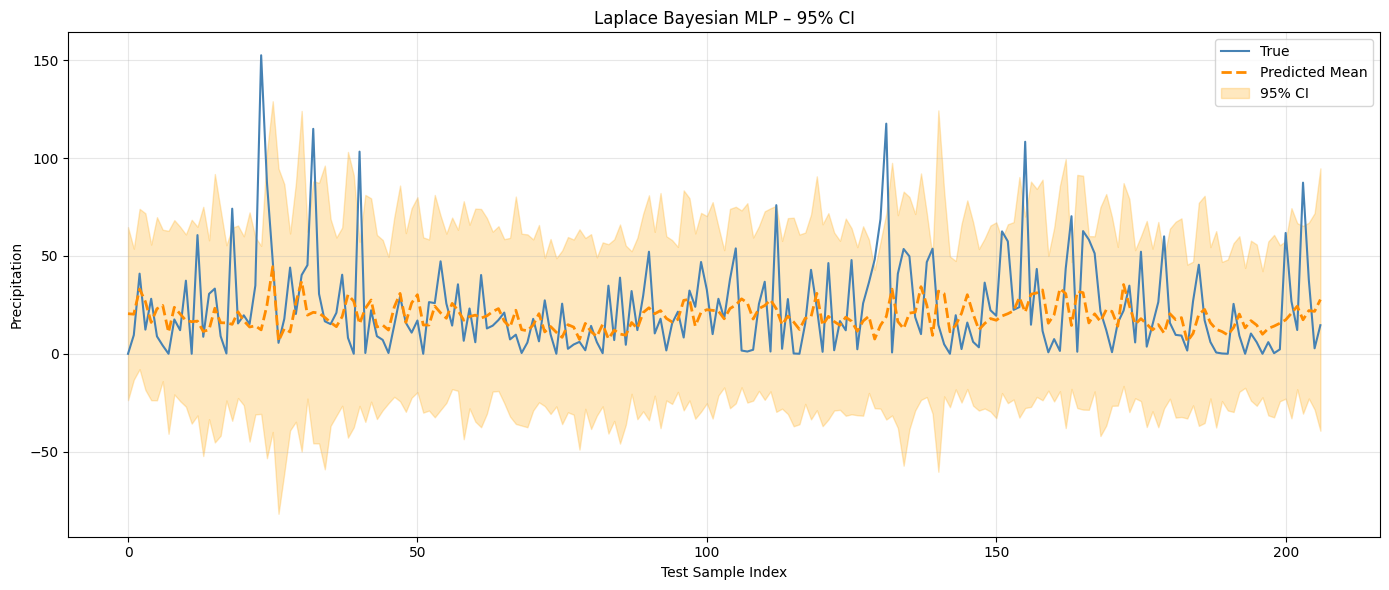

In [252]:
mc_mean_lap, mc_std_lap, samples_lap = laplace_bnn_predict(model, test_loader, y_scaler, T=100, device=device)
_, targets_lap = evaluate_model_lap(model, test_loader, y_scaler)

nll_lap = nll_gaussian(mc_mean_lap, mc_std_lap, targets_lap)
cov80_lap = compute_coverage(mc_mean_lap, mc_std_lap, targets_lap, alpha=0.80)
cov95_lap = compute_coverage(mc_mean_lap, mc_std_lap, targets_lap, alpha=0.95)

print(f"[Laplace BNN] NLL: {nll_lap:.3f}")
print(f"[Laplace BNN] 80% coverage: {cov80_lap * 100:.2f}%")
print(f"[Laplace BNN] 95% coverage: {cov95_lap * 100:.2f}%")

plot_uncertainty(mc_mean_lap, mc_std_lap, targets_lap,
                 title="Laplace Bayesian MLP – 95% CI")
